<a href="https://colab.research.google.com/github/stellaa61/AI_Health_Care/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%8B%AC%ED%99%94_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 요구사항 정의

- 감상선암환자 데이터를 이용한 `ML 모델 구축`
  - 모델 타입 : 판별 모델 (머신러닝>지도학습>분류)
    - 정상 or 암
  - 데이터
    - 훈련데이터 : `train.csv`
    - 예측해야된 데이터 : test.csv
    - 예측값을 세팅후 제출(캐글)하는 데이터 : sample_submission.csv
  - 정답
    - `정상(0) or 암(1)` => 진단 => 판별
    - 머신러닝 > 지도학습 > 분류의 문제
      - `이진 분류`

- 전체 워크플로우의 마지막 단계 -> ML 모델을 이용한 서비스(gradio or streamlit) or 구축


# 데이터 수집/획득

- ETL(추출, 변환, 적재)
  - 모델 학습에 필요한 데이터를 처리하고 데이터 엔진니어 파트(DE)에서 주로 보는 업무중 하나임
  - 데이터 수집/획득 -> Extact(추출) 절차와 연관

- 수집
  - [ V ] level 1
    - 사내데이터, 혹은 `제공된 데이터`
    - 공공데이터, 데이터 거래소에서 구매
    - 의료 데이터는 주로 보안등등 사내 데이터나 등등로 해결
  - [ ] level 2
    - openAPI 활용 (웹 환경)
  - [ ] level 3
    - web scrapping (웹 스크래핑)
  - [ ] level 4
    - crawling (크롤링-selenium) or LLM 기반 기술에서 MCP(도구)에서 다양한 크롤링기술 제공

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일등 설정
plt.style.use('ggplot')

In [ ]:
# 1. 데이터 로드 (csv -> df)
#    대용량 데이터 x, 중/소 크기의 데이터 o
train       = pd.read_csv('/content/train.csv')
test        = pd.read_csv('/content/test.csv')
submission  = pd.read_csv('/content/sample_submission.csv')

# 2. 데이터 볼륨 확인
train.shape, test.shape, submission.shape
# 훈련데이터와 테스트 데이터 간에 정답(타겟, 레이블, 클레스, 종속변수) 컬럼 1개 차이남

((87159, 16), (46204, 15), (46204, 2))

# 데이터 준비/전처리 + 분석

- 참고
  - 데이터사이언스(분석 중심)
    - EDA, 상관관계, ...
  - 머신러닝 -> 데이터 준비에 통합운영
    - 피처 엔지니어링 위한 `EDA 중심`

- 목표
  - 데이터의 품질 향상
    - 모델 학습에 적합한 형태로 데이터 전처리(가공,..)
  - 해당 데이터에 대한 `통찰`을 얻는 행위
    - `데이터에 대한 이해`
  - 데이터간 `(피처, 타겟) 관계, 특성(징)등을 파악`
    - Automl 사용 -> 최적 알고리즘 구성 완료
    - 데이터에서 모델 성능은 판별 -> 데이터를 전처리, 피처 엔지니어링을 통해서 최적 형태로 데이터를 준비 -> ML 모델 구축(모델러)하는 기술의 차이

## 데이터 기본 점검

### 인사이트 제공

In [ ]:
# 컬럼 확인
'''
[
 'ID', -> 개인별 구분용 -> 학습 x
 '나이', '성별', '국가', '인종', '가족력', -> 범주형 예상
 '방사선 치료 이력', '요오드 결핍', '흡연', '체중 위험도', -> 범주형 예상
 '당뇨병',
 '결절 크기', => Nodule_Size
 'TSH 결과',  => 갑상선 자극 호르몬 -> 방사성 요오드 치료 후 의도적으로 낮춤 -> 치료 효과를 모니터링하는 지표
 'T4 결과',   => 티록신 -> 갑상선에서 생성되는 주요 호르몬 ->  신진대사 조절
 'T3 결과',   => 트리요오드티로닌-> 갑상선에서 생성되는 주요 호르몬 ->  에너지 수준을 조절

 '암'      => 판정데이터(정답, 레이블)
 ]
'''
train.columns

Index(['ID', 'Age', 'Gender', 'Country', 'Race', 'Family_Background',
       'Radiation_History', 'Iodine_Deficiency', 'Smoke', 'Weight_Risk',
       'Diabetes', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result',
       'Cancer'],
      dtype='object')

In [ ]:
# 샘플 확인
train.sample(2)
# 피처데이터 = 범주형 + 수치형
# 정답데이터 = 0과 1 => 이산형

,ID,Age,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes,Nodule_Size,TSH_Result,T4_Result,T3_Result,Cancer
69950,TRAIN_69950,63,F,BRA,MDE,Positive,Exposed,Sufficient,Smoker,Not Obese,Yes,0.740151,2.005362,9.551295,1.342267,0
23434,TRAIN_23434,64,F,IND,ASN,Negative,Unexposed,Sufficient,Non-Smoker,Not Obese,Yes,4.640666,0.683121,4.817577,2.665551,0


In [ ]:
# 테스트 데이터 => 정답 x 여부 확인
test.head(2)

,ID,Age,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes,Nodule_Size,TSH_Result,T4_Result,T3_Result
0,TEST_00000,53,M,NGA,CAU,Negative,Unexposed,Sufficient,Non-Smoker,Not Obese,No,2.940678,6.434501,9.227958,2.733846
1,TEST_00001,46,M,KOR,MDE,Negative,Unexposed,Deficient,Smoker,Obese,No,3.450129,4.729535,5.937664,0.775012


In [ ]:
# 제출용 파일
# test와 동일 ID를 가짐
# test => 모델 주입
#      => 예측 => 결과(predict()) 혹은 암일 확률(predict_prob()) => 세팅 => 제출
submission.head(2)

,ID,Cancer
0,TEST_00000,0
1,TEST_00001,0


In [ ]:
# 데이터수(87159), 피처 데이터 타입(object, int64, float64),
# 결측치 존재여부(x, 실 데이터는 많이 존재할수 있음), 메모리 사이즈(10.6+ MB)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87159 entries, 0 to 87158
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 87159 non-null  object 
 1   Age                87159 non-null  int64  
 2   Gender             87159 non-null  object 
 3   Country            87159 non-null  object 
 4   Race               87159 non-null  object 
 5   Family_Background  87159 non-null  object 
 6   Radiation_History  87159 non-null  object 
 7   Iodine_Deficiency  87159 non-null  object 
 8   Smoke              87159 non-null  object 
 9   Weight_Risk        87159 non-null  object 
 10  Diabetes           87159 non-null  object 
 11  Nodule_Size        87159 non-null  float64
 12  TSH_Result         87159 non-null  float64
 13  T4_Result          87159 non-null  float64
 14  T3_Result          87159 non-null  float64
 15  Cancer             87159 non-null  int64  
dtypes: float64(4), int64(2

In [ ]:
# 통계 요약-> 수치형 데이터만 집계됨
# std 체크
# 연속형 : Nodule_Size	TSH_Result	T4_Result	T3_Result -> 0에 가깝다
# Age 값이 비교젹 크지만 => 성격상 범주형처럼 다뤄 질수도 있어서 eda 통해 파악
train.describe()

,Age,Nodule_Size,TSH_Result,T4_Result,T3_Result,Cancer
count,87159.000000,87159.000000,87159.000000,87159.000000,87159.000000,87159.000000
mean,50.860244,2.508098,5.056871,8.248796,2.005002,0.119999
std,21.638687,1.441928,2.861229,2.165975,0.867013,0.324962
min,14.000000,0.000000,0.100000,4.500000,0.500000,0.000000
25%,32.000000,1.270332,2.582845,6.372031,1.254836,0.000000
50%,51.000000,2.520941,5.059085,8.236789,2.004101,0.000000
75%,70.000000,3.760938,7.541586,10.126981,2.758032,0.000000
max,88.000000,5.000000,10.000000,12.000000,3.500000,1.000000


### 피처 요약표 -> 데이터를 파악

- 피처명, 형상(볼륨), 타입, 결측치, 고유값수(중요), 샘플값

In [ ]:
def summary_feature_info( src_df ):
  '''
    컬럼 구조
    feature_name | dtype | 결측치수 | 고유값수 | 샘플값_0 | 샘플값_1 | 샘플값_2
  '''
  df_info = pd.DataFrame()
  # 컬럼명
  df_info['feature_name']   = src_df.columns
  df_info['dtype']   = src_df.dtypes.values
  # 결측치
  df_info['결측치']   = src_df.isnull().sum().values
  df_info['고유값수'] = src_df.nunique().values
  # 샘플값
  df_info['샘플값_0'] = src_df.sample(1).values[0]
  df_info['샘플값_1'] = src_df.sample(1).values[0]
  df_info['샘플값_2'] = src_df.sample(1).values[0]
  return df_info

In [ ]:
summary_df = summary_feature_info( train )
'''
- 해석
- ID : 87159개 => 데이터 개수와 동일 => 학습 x => 불필요한 컬럼 제거에 대상이됨
- 수치형(연속형) -> 연속형이므로 고유값의 개수가 데이터 총수와 같을수 있음->회귀적 내용->문제없음
  - Nodule_Size
  - TSH_Result
  - T4_Result
  - T3_Result
- 범주형, 수치형(이산형) => 고유값의 개수가 다양 => 원핫 인코딩 유력함
  - Age -> 이산형
  - Gender, Family_Background, Radiation_History, Iodine_Deficiency
    Smoke, Weight_Risk, Diabetes
    -> 고유값 2개 -> 이진형 처리(0과 1) -> (라벨|원핫)인코딩처리
  - 나머지 -> 명목형
'''
summary_df

,feature_name,dtype,결측치,고유값수,샘플값_0,샘플값_1,샘플값_2
0,ID,object,0,87159,TRAIN_76129,TRAIN_69695,TRAIN_25565
1,Age,int64,0,75,34,15,82
2,Gender,object,0,2,M,F,M
3,Country,object,0,10,NGA,DEU,NGA
4,Race,object,0,5,ASN,HSP,CAU
5,Family_Background,object,0,2,Positive,Negative,Negative
6,Radiation_History,object,0,2,Unexposed,Unexposed,Unexposed
7,Iodine_Deficiency,object,0,2,Deficient,Sufficient,Sufficient
8,Smoke,object,0,2,Non-Smoker,Non-Smoker,Non-Smoker
9,Weight_Risk,object,0,2,Not Obese,Not Obese,Not Obese


## EDA

- 데이터 분석이 아닌, 피처 엔진니어링, 모델 학습에 도움이되는 피처 구분하는등

### 타겟(레이블) 데이터 분석

- 비율 체크(분포 확인)

- 점검 포인트
  - 정답 비율 체크
    - `층화 추출`(stratified sampling) 기능 고려
    - 전체 데이터에서 정답의 고유값별 비율을 학습/테스트 데이터로 분할할때 `강제 유지`하는 내용
    - 적용
      - train/test 분할
      - 교차 검증 수행시
  - 도메인별 특성
    - `의료 데이터 기준`
      - 질병이 있는(Positive) 환자가 정상(질병 없다:Negative) 환자보다 훨씬 적다(명제)
      - 정답 데이터의 비율이 이를 따르는가? 체크가 중요함
        - 그 비율이 5% 이내라면 데이터적 결함 존재함 => 데이터 추가 확보 필요 (`통상 최저 10% 이상 권장`)
        - 감상선암 데이터에서 암환자 데이터가 10% 이상 권장함
          - 많을 수록 좋음
            - 데이터가 적을수록(10% -+ 인근) -> 사용할수 있는 모델의 선택 제한이 걸림


In [ ]:
# 타겟 데이터 고유값별 카운트
target_counts = train['Cancer'].value_counts()
# 개수는 보이고 비율이 않보임
target_counts

,count
Cancer,
0,76700
1,10459


In [ ]:
target_ratio = train['Cancer'].value_counts(normalize=True)
# 개수는 보이고 비율이 않보임
target_ratio
# 암환자 데이터가 전체 데이터에서 11.9% 비중 이므로 => 학습 사용에 적합함

,proportion
Cancer,
0,0.880001
1,0.119999


##### 결론


- 만약 암 환자 비율이 5% 미만이라면, 추후 모델링 시 SMOTE 같은 오버샘플링이나 Class Weight 조절이 필요함.
    ```
        - 만약 전체 환자 100명 중 암 환자가 5명(5%), 정상인이 95명(95%)이라고 가정
        - 모델이 아무런 학습도 하지 않고, 무조건 **"모두 정상입니다"**라고 찍어서 대답한다면?
            - 정확도(Accuracy): 95% (95명은 맞췄음)
            - 실제 문제: 암 환자 5명은 단 한 명도 찾아내지 못했음(`Recall/재현율 0%`)
            - 의료 현장에서 **"암 환자를 놓치는 것(FN:False Negative, 위음성)"**은 단순히 틀린 것이 아니라 환자의 생명을 위협하는 치명적인 실수임
            - 데이터가 불균형하면 모델은 **"어차피 소수 클래스(암)는 무시하고 다수 클래스(정상)로만 예측해도 점수가 잘 나오네?"**라고 학습해버림
        - 해결
            - Class Weight (가중치 조절)
                - 모델에게 **"채점 기준"**을 바꿔주는 방식
                - 기존: 정상인 1명 틀리면 감점 -1점, 암 환자 1명 틀려도 감점 -1점.
                - Class Weight 적용: 정상인 틀리면 감점 -1점, 암 환자 틀리면 감점 -20점
                - 강제 : 암 환자를 틀리면 페널티가 엄청 크니까 집중해
                - 데이터 개수를 건드리지 않고 알고리즘 내부적으로 소수 클래스의 중요도를 높이는 방법
                - Scikit-learn 모델들에 class_weight='balanced' 옵션이 있는 이유
            - SMOTE (오버샘플링)
                - 데이터 자체를 늘려주는 방식
                - Synthetic Minority Over-sampling Technique
                    - 부족한 데이터를 복사+붙여넣기 해서 늘리는 것
                    - 새로운 가짜 데이터를 만들어

    ```
- 현 데이터는 11% 이므로 사용 가능

### 피처별 데이터 분석

#### 수치형(이산,연속)

In [ ]:
train.columns
# 'Age', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result'

Index(['ID', 'Age', 'Gender', 'Country', 'Race', 'Family_Background',
       'Radiation_History', 'Iodine_Deficiency', 'Smoke', 'Weight_Risk',
       'Diabetes', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result',
       'Cancer'],
      dtype='object')

In [ ]:
numeric_cols = ['Age', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result']
numeric_cols

['Age', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result']

##### 피처 데이터 분포 대비 정답 비율- 시각화

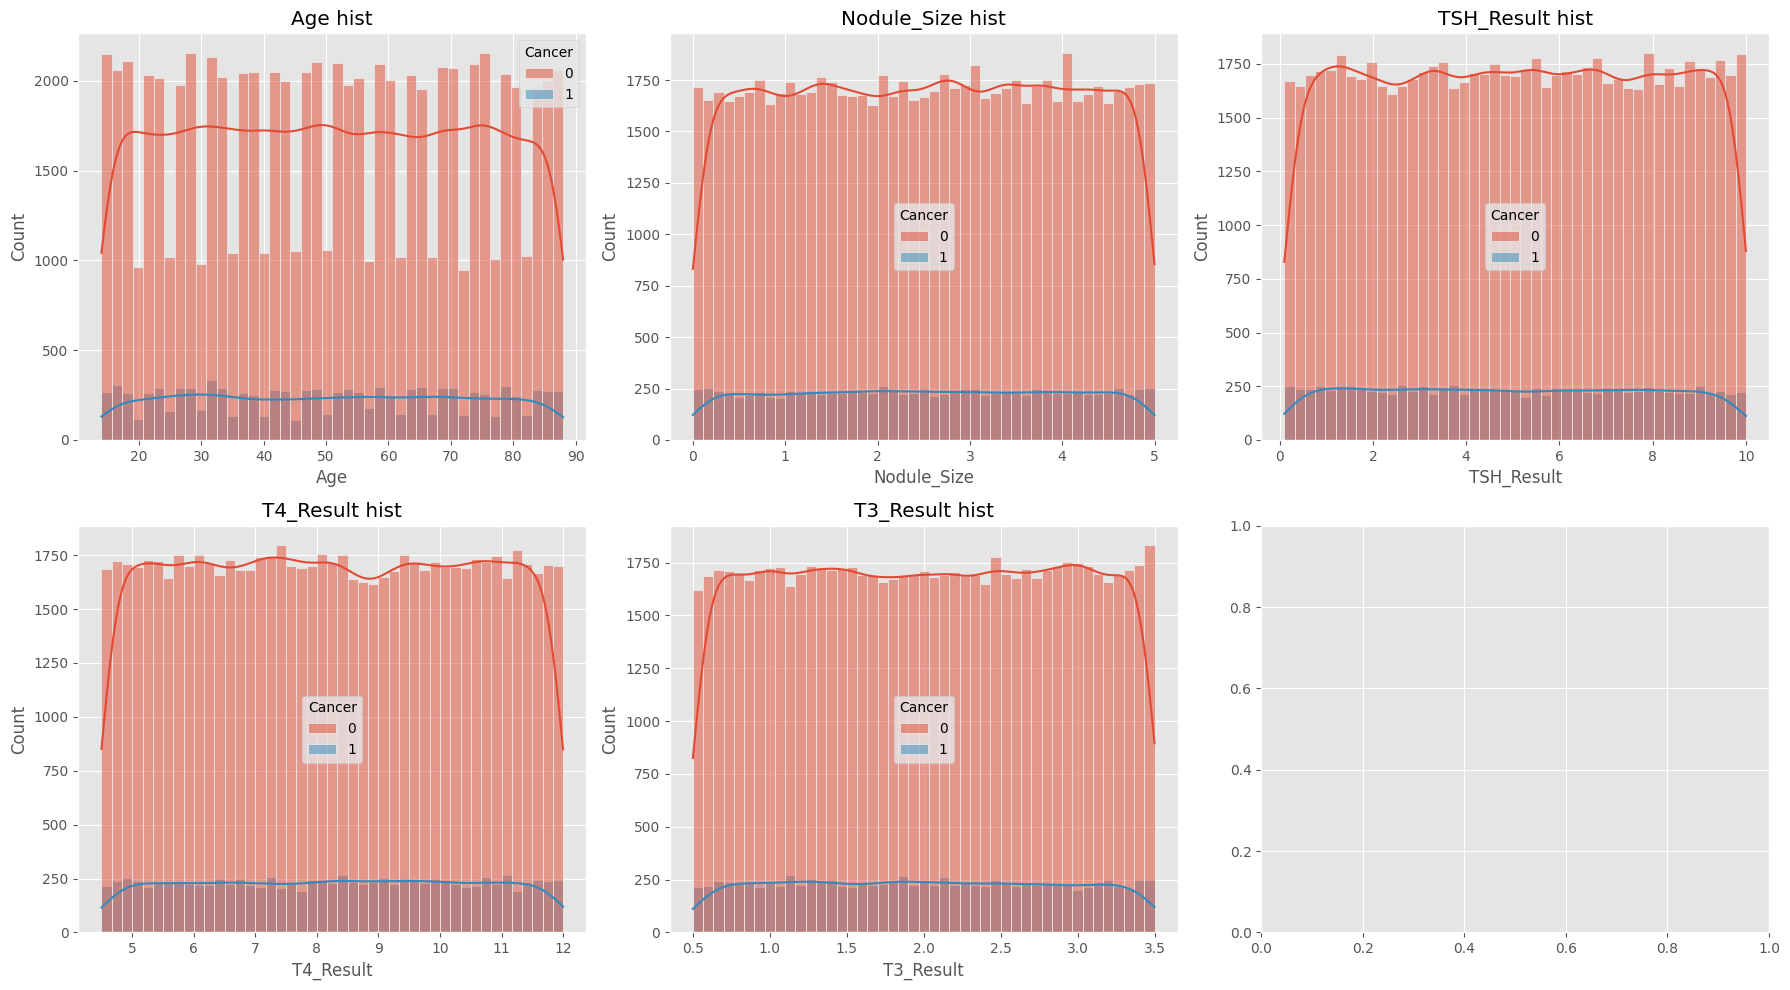

In [ ]:
# 피처 5개 이므로 한줄에 3개씩 포현 -> 총 2줄로 표현
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# 연속형 데이터 -> 구간화하여 표현(밀도)
axes      = axes.flatten()

for i, col in enumerate(numeric_cols):
  sns.histplot(data=train, x=col, hue='Cancer', kde=True, ax=axes[i])
  axes[i].set_title(f'{col} hist')

plt.tight_layout()
plt.show()

# 주황생:0:정상
# 블루:1:암
# 연속형 데이터 => 일관성 있게 정상과 암의 비율이 일정함
# 이산형 데이터 => 2000:250, 1000:125 비율로 타겟값이 세팅 => 일정한 비율을 유지
# 데이터 불균형임에도 불구하고 , 타겟값들이 모든 피처에 전반적으로 동일하게 구성되어 있음 => 학습 사용에 문제 x
# 층화 비율 유지하면 적절하게 구성
# 날것의 현장 데이터에 비해 정제된 데이터임 체크(참고)

##### 이상치 체크

- 목표
  - 데이터가 많다면 통상 추출하여 제거 고민(종합적인 검토 필요)
- 검출 기법
  - [V] Tunkey Fences (4분위수를 활용)
    - 가장 간단, 빠르게 체크 가능
    - `박스 플록` 시각화에서 진단 가능
  - Z-Score
    - 통계적 기법
  - DBSCAN
    - 머신러닝>비지도학습>군집화(클러스터링)>제공되는 알고리즘
  - isolation Forest
    - 앙상블 알고리즘
  - LOF(Local Outlier Factor)
    - 최근접 이웃 알고리즘

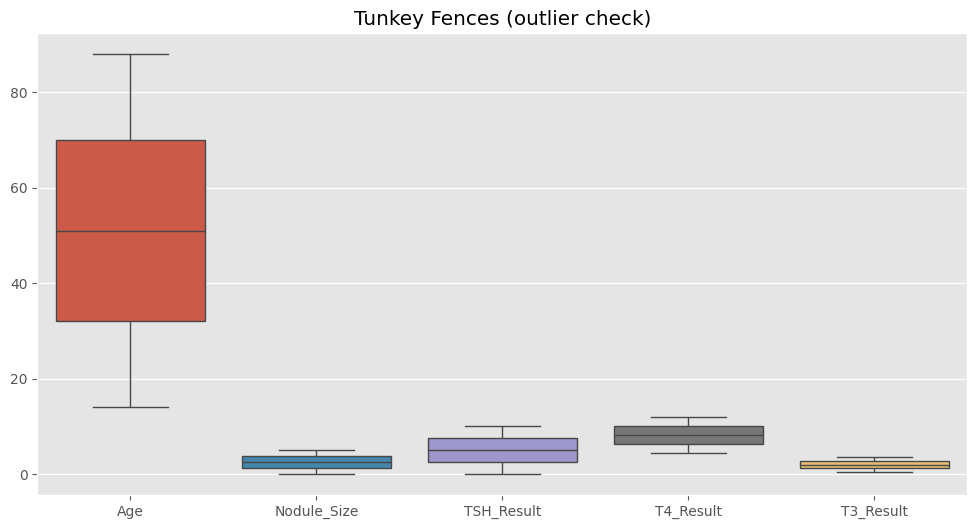

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot( data=train[numeric_cols])
plt.title('Tunkey Fences (outlier check)')
plt.show()

# 차트상으로는 이상치가 보이지 않음

In [ ]:
# 코드로 확인 - Tunkey Fences outlier check
for col in numeric_cols:
  # Q1 = 하위 25%값
  Q1 = train[col].quantile(0.25)
  # Q3 = 상위 75%값
  Q3 = train[col].quantile(0.75)
  # IQR = Q3 - Q1
  IQR = Q3 - Q1

  # 이상치
  outlier_std = 1.5*IQR
  # Q1 - 1.5*IQR 보다 작은값
  # Q3 + 1.5*IQR 보다 큰값
  # 작거나 큰값 체크 =>df에서 블리언 인덱싱 수행 => 대상이 되는 데이터 획득
  cnt = train[ ( train[col] < Q1-outlier_std ) | ( train[col] > Q3+outlier_std ) ].shape[0] # 조건을 만족하는 총 데이터수

  print( col, f'의 이상치 개수 {cnt} 개' )
  #break

Age 의 이상치 개수 0 개
Nodule_Size 의 이상치 개수 0 개
TSH_Result 의 이상치 개수 0 개
T4_Result 의 이상치 개수 0 개
T3_Result 의 이상치 개수 0 개


- 이상치 점검 결과
  - 수치형 데이터에는 이상치 없음 -> 제거할 데이터 없음

##### 상관관계 체크

- 강한 상관관계를 가진 피처간에 1개는 제거 할 수 있다(후보군)
  - 종합적 검토 후 조치
  - 대상이 있는지 확인

In [ ]:
corr_matrix = train[ numeric_cols ].corr()
# -1 ~ 1 사이 값을 가지고, 0에 가까울수록 상관관계가 없다(-1, 1에 가까울수록 강한 상관관계)
corr_matrix
# 현재 표 기준으로는 대부분 -0.00... ~ 0.00... 사이 값을 상관계수로 가짐 => 상관관계 없다 => 제거 변수 x

,Age,Nodule_Size,TSH_Result,T4_Result,T3_Result
Age,1.000000,-0.004258,-0.001557,-0.006199,0.003293
Nodule_Size,-0.004258,1.000000,0.000209,0.002767,-0.003523
TSH_Result,-0.001557,0.000209,1.000000,-0.002409,-0.000228
T4_Result,-0.006199,0.002767,-0.002409,1.000000,-0.001437
T3_Result,0.003293,-0.003523,-0.000228,-0.001437,1.000000


<Axes: >

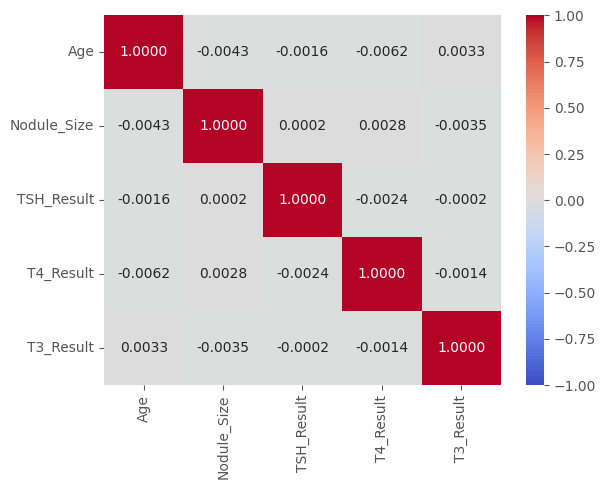

In [ ]:
# 히트맵을 이용하여 표현
sns.heatmap(corr_matrix, annot=True, fmt='.4f',
            cmap='coolwarm', # 음의 상관관계 블루 <-> 레드
            vmin=-1, vmax=1
            )

- 상관관계 분석 결과
  - 피처간 상관계수는 모두 -0.00... ~ 0.00... 사이 값을 가짐
  - 상관관계 없다 -> 상호간 독립적이다
  - 제거할 피처 없다

##### 분포도 분석

- 데이터 분포가 한쪽으로 쏠리는등(왜도, 첨도등) 점검하여 데이터 분포를 조절
- 분포를 스케일리 처리 기법 -> 정규분포에 가깝도록 데이터 스케일링
  - 로그 변환
  - 박스콕스 변환
  - 여존슨 변환
- 분포도 체크 => 왜도등 점검 => 변환 처리가 필요한지 체크

Age 0.005805158710140685


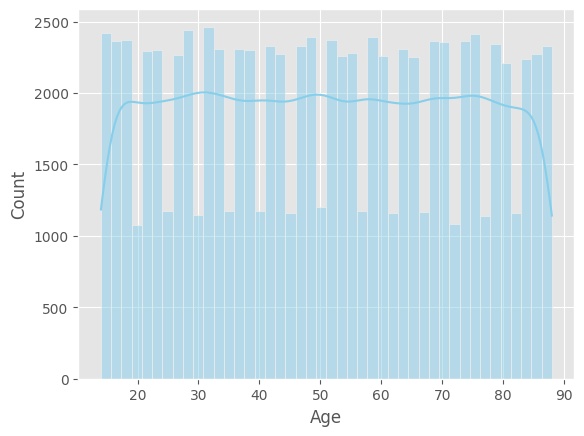

Nodule_Size -0.007023281605521997


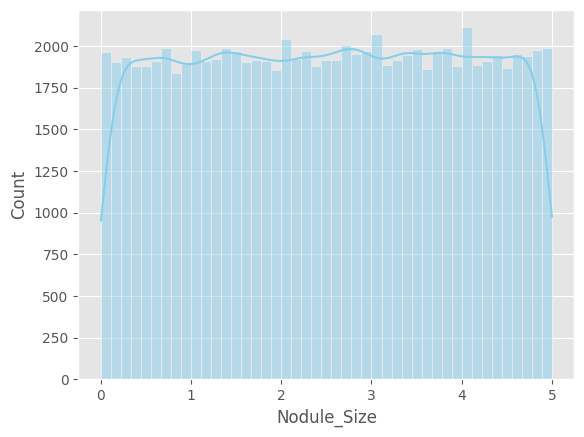

TSH_Result -0.0004094701273052949


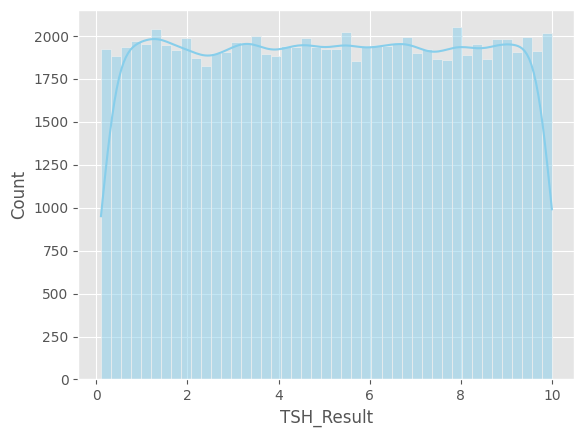

T4_Result 0.00238965475378651


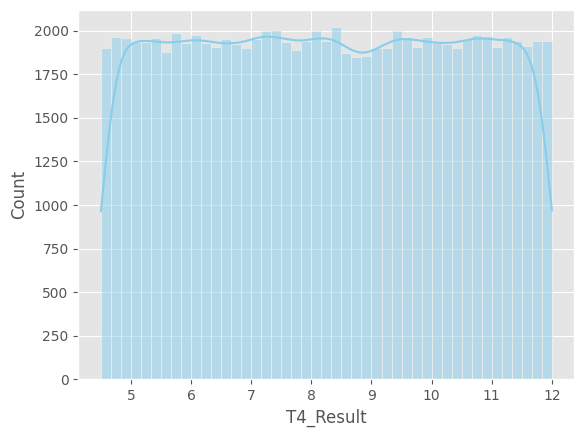

T3_Result -0.0001276803460522113


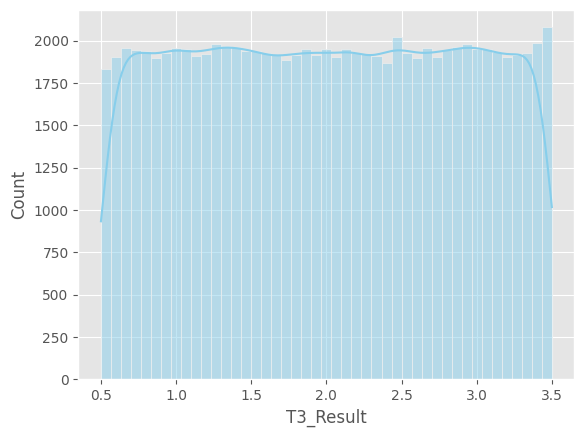

In [ ]:
'''
- 왜도값이 0.05 이하면 매우 낮음
  - 해석 : 데이터가 아주 고르게 퍼져 있다, 변환 과정 필요 x
'''
for col in numeric_cols:
  ori_data   = train[col] # 특정 수치형 데이터
  skew_value = ori_data.skew() # 왜도값
  print( col, skew_value)

  sns.histplot( ori_data, kde=True, color='skyblue')
  plt.show()

- 위에서 컬럼별 왜도값 체크할 결과 변환 과정 필요 없다!!
  -  -0.00.. ~ 0.005
  - 변환없이 원본 그대로 사용 (1차적 확정)

#### 범주형(명목,순서)

In [ ]:
train.columns

Index(['ID', 'Age', 'Gender', 'Country', 'Race', 'Family_Background',
       'Radiation_History', 'Iodine_Deficiency', 'Smoke', 'Weight_Risk',
       'Diabetes', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result',
       'Cancer'],
      dtype='object')

In [ ]:
# 직관을 통해 암진단에 도움이 되는 컬럼(성별, 흡연여부, 가족력..)
cate_cols = [
  'Gender', 'Country', 'Race', 'Family_Background',
  'Radiation_History', 'Iodine_Deficiency', 'Smoke', 'Weight_Risk',
  'Diabetes'
]
cate_cols

['Gender',
 'Country',
 'Race',
 'Family_Background',
 'Radiation_History',
 'Iodine_Deficiency',
 'Smoke',
 'Weight_Risk',
 'Diabetes']

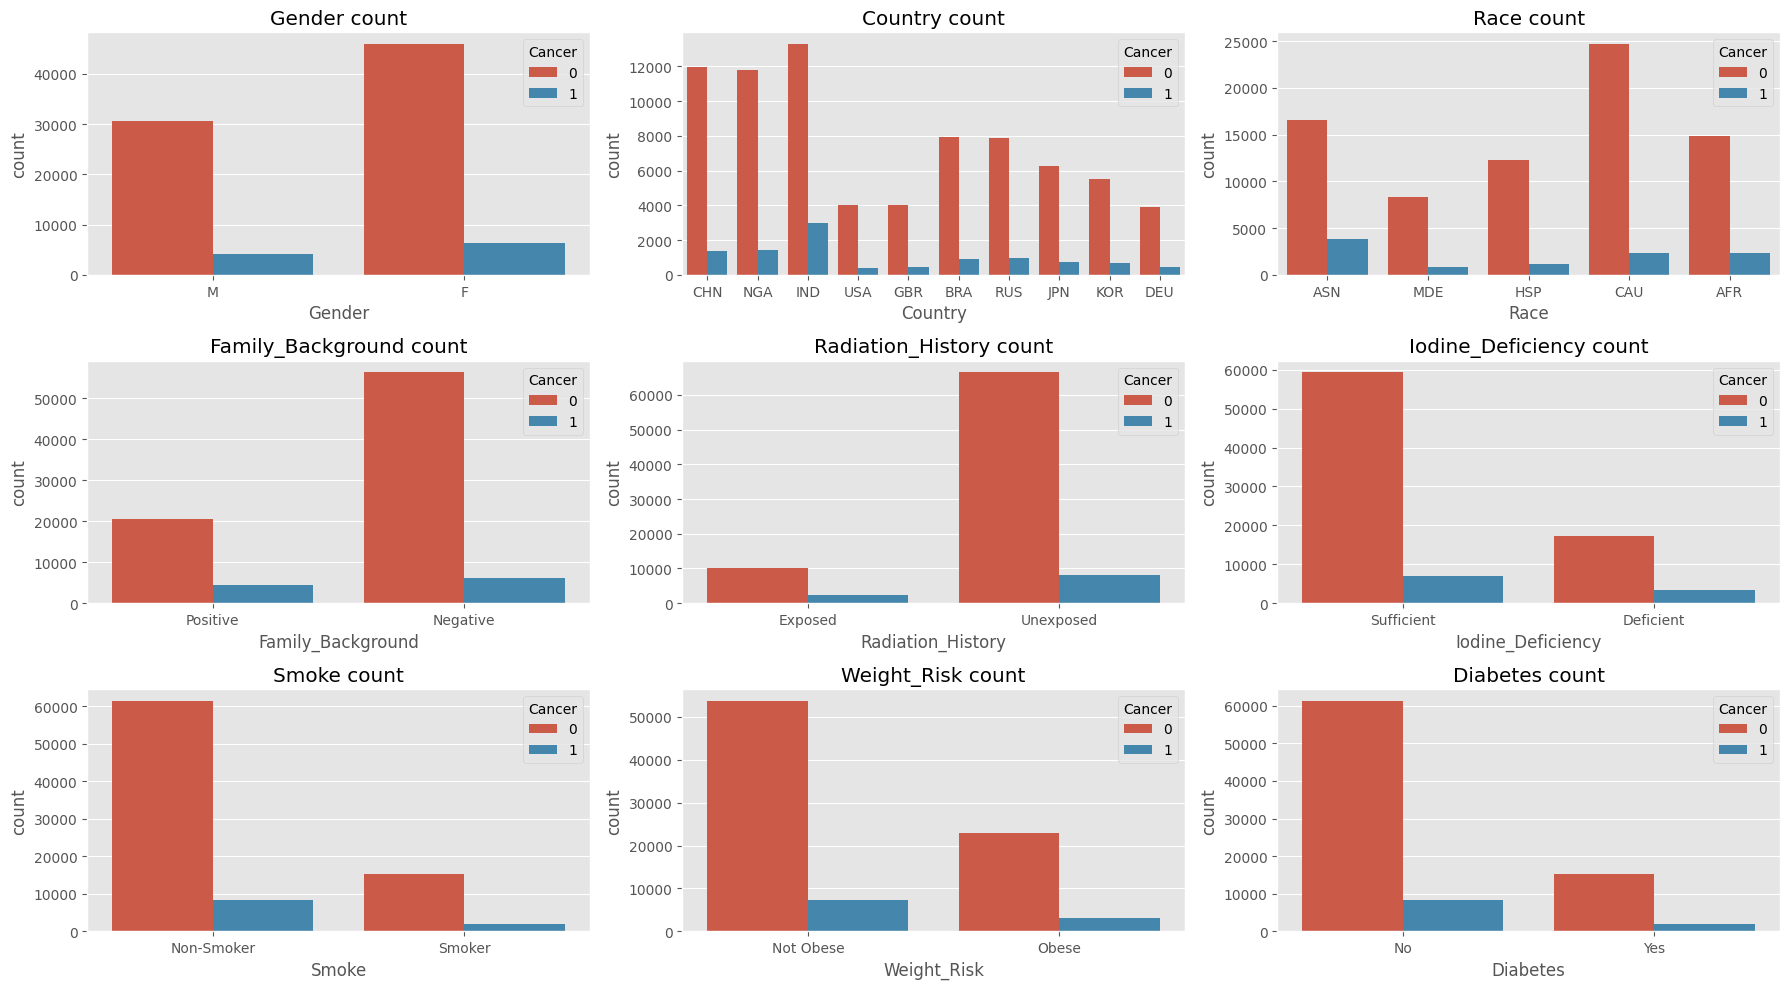

In [ ]:
# 수치형 => 히스토그램, 범주형 => 카운트(빈도)
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes      = axes.flatten()

for i, col in enumerate(cate_cols):
  sns.countplot(data=train, x=col, hue='Cancer', ax=axes[i])
  axes[i].set_title(f'{col} count')

plt.tight_layout()
plt.show()

- 해석
  - 정상과, 암에 대한 정답 비율이 모든 피처에서 동일하게 추세가 보임
    - 정상 데이터가 압도적으로 높고(비율 계산은 별개로 체크), 암의 비율은 낮음
  - 개별 피처의 정답(정상, 암)의 높이가 모두 제각각(정상 비율)
    - 단, 암의 비율응 개수가 적은 관계로 큰 차이가 않남(개별적으로 존제) -> 차이점들은 학습에 도움이됨


##### 피처별 암발병율에 대한 카운트 및 비율

In [ ]:
for col in cate_cols:
  # 대상 컬럼 => 피벗 진행
  df = pd.pivot_table( train, index=col, values='Cancer', aggfunc=['count','mean'])
  print(f'{col} 암 발병 현황')
  display( df )
  print('-'*20)
  #break

Gender 암 발병 현황


,count,mean
,Cancer,Cancer
Gender,,
F,52248,0.119832
M,34911,0.120249


--------------------
Country 암 발병 현황


,count,mean
,Cancer,Cancer
Country,,
BRA,8856,0.105578
CHN,13367,0.103239
DEU,4382,0.104518
GBR,4484,0.106378
IND,16309,0.184499
JPN,7005,0.101784
KOR,6219,0.108378
NGA,13217,0.106076


--------------------
Race 암 발병 현황


,count,mean
,Cancer,Cancer
Race,,
AFR,17155,0.136229
ASN,20363,0.185975
CAU,27090,0.087781
HSP,13471,0.086037
MDE,9080,0.087885


--------------------
Family_Background 암 발병 현황


,count,mean
,Cancer,Cancer
Family_Background,,
Negative,62430,0.098078
Positive,24729,0.175341


--------------------
Radiation_History 암 발병 현황


,count,mean
,Cancer,Cancer
Radiation_History,,
Exposed,12398,0.179787
Unexposed,74761,0.110084


--------------------
Iodine_Deficiency 암 발병 현황


,count,mean
,Cancer,Cancer
Iodine_Deficiency,,
Deficient,20807,0.166386
Sufficient,66352,0.105453


--------------------
Smoke 암 발병 현황


,count,mean
,Cancer,Cancer
Smoke,,
Non-Smoker,69889,0.11989
Smoker,17270,0.12044


--------------------
Weight_Risk 암 발병 현황


,count,mean
,Cancer,Cancer
Weight_Risk,,
Not Obese,61038,0.119516
Obese,26121,0.121129


--------------------
Diabetes 암 발병 현황


,count,mean
,Cancer,Cancer
Diabetes,,
No,69736,0.119952
Yes,17423,0.120186


--------------------


In [ ]:
cate_cols

['Gender',
 'Country',
 'Race',
 'Family_Background',
 'Radiation_History',
 'Iodine_Deficiency',
 'Smoke',
 'Weight_Risk',
 'Diabetes']

- 암 발병율 비율 점검
  - Race, Family_Background 등 중요 피처들(발병율에 차이가 상대적으로 큼)이 확인됨
  - Smoke, Gender등은 큰 차이를 않 보임

- 일단 학습에는 모두 사용
  - 미세한 차이도 그 조합에 대한 영향력이 발생될수 있음

### 결론(피처엔지니어링 전략)

- ID 컬럼을 제외한 모든 피처 학습시 사용
- 연속형 데이터는 상호 독립적임
  - 필요시 구간화 하여 범주형으로 구성 가능함 (호르몬 수치등, T3/T4 계열 데이터등)
    - 파생 변수 생성 가능

## 피처엔지니어링



- 모델 학습 이전에 완료
- 데이터 정제(클리닝)
  - 결측치 처리
  - 이상치 처리
  - 범주형 데이터 => 수치화
    - 피처 인코딩
      - 라벨 인코딩
      - 원핫 인코딩
      - 순서 인코딩
      - ...
  - 수치형 데이터
    - 정규화
    - 피처 스케일링
      - StandardScaler
      - MinMaxScaler
      - ...

### Transform(변환) - 전처리(preprocessing)

- 데이터의 수치화

#### 불피요한 컬럼 제거

In [ ]:
# ID 제거
print( 'ID 컬럼 제거전',  train.shape, test.shape )

# 훈련 데이터, 제출용 테스트 데이터 모두 가능(단, 테스트데이터, 서브미션 데이터순서는 동일함)
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)


#print( 'ID 컬럼 제거후',  temp.shape, test.shape )

#### 결측치 처리

In [ ]:
train.isnull().sum() > 0
# 모든 피처에서 결측치 없음

,0
Age,False
Gender,False
Country,False
Race,False
Family_Background,False
Radiation_History,False
Iodine_Deficiency,False
Smoke,False
Weight_Risk,False
Diabetes,False


- 결측치 처리
  - SimpleImputer 클레스 활용
  - 수치형 데이터
    - 이상치 여부
      - 이상치 존재할때
        - 중앙값(median)으로 채우기
        - 관련 스케일링 : Robustscaler
      - 이상치 없을때
        - 평균값으로 채우기
        - 관련 스케일링 : standardscaler
    - 시계열
      - 이전값, 다음값으로 세팅
      - 이전/다음값을 중간값
  - 범주형 데이터
    - 최빈값(자주 등장하는 값) 세팅

- 결론
  - 결측치가 없으므로 생략

In [ ]:
from sklearn.impute import SimpleImputer

'''
SimpleImputer(strategy='mean'|'median'|'most_fr...'|'상수')
fit() or fit_transform() 활용 => 결측치 일괄 처리됨
'''

"\nSimpleImputer(strategy='mean'|'median'|'most_fr...'|'상수')\nfit() or fit_transform() 활용 => 결측치 일괄 처리됨\n"

#### 이상치 처리

- 이상치 없음 -> 생략

#### 데이터 인코딩 (범주형->수치화)

- 라벨, 순서, 원-핫,...
- 범주형 데이터의 수치화
- 필요시 연속형 데이터를 구간화등등

In [ ]:
# 범주형 데이터를 수치화 처리
from sklearn.preprocessing import LabelEncoder

# 범주형 데이터 선택 -> 9개
# train[ cate_cols ].shape
for col in cate_cols:
  train[ col ] = LabelEncoder().fit_transform( train[ col ] )
  # 고려사항
  # ml 경우 0, 1, 2 있을 경우 0을 기준으로 1이 2보다 더 가깞다고 인지 -> 해결 -> 원핫인코딩 사용
  # 원핫 인코딩 -> 피처수가 급격하게 증가함(고유값개수만큼) -> 학습 비용 상승, 여러 문제도 내제되어 있음 -> 압축해서 사용(희소 행렬 처리)
  # 라벨 인코딩 처리값도 알고리즘에 따라 다르게 반응 할수 있음 -> 다양함 체크및 시도가 필요함

train[ cate_cols ].sample(2)

,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes
16386,0,7,0,1,1,0,0,1,0
76009,0,7,2,1,1,1,0,0,1


- 범주형 데이터가 모두 수치로 변경됨
  - 라벨 인코더 -> 트리 기반 알고리즘 적합(RandomForest, XGBoost)
  - 원핫 인코더 -> 선형 모델 계열 알고리즘 적합(Logistic Regression, ...)

- 테스트 데이터도 라벨 인코더 처리 필요

In [ ]:
summary_feature_info( train[ cate_cols ] )

,feature_name,dtype,결측치,고유값수,샘플값_0,샘플값_1,샘플값_2
0,Gender,int64,0,2,1,0,1
1,Country,int64,0,10,4,1,0
2,Race,int64,0,5,2,2,1
3,Family_Background,int64,0,2,0,1,1
4,Radiation_History,int64,0,2,1,1,1
5,Iodine_Deficiency,int64,0,2,1,1,0
6,Smoke,int64,0,2,0,0,0
7,Weight_Risk,int64,0,2,0,0,0
8,Diabetes,int64,0,2,0,0,0


#### 데이터 스케일링

- StandardScaler
- MinMaxScaler
- ...

In [ ]:
- 스탠다드(정규분포를 따르는) 스케일링 일괄적용

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train[ numeric_cols ] = scaler.fit_transform( train[ numeric_cols ] )

display( train[ numeric_cols ].head(2) )

# 해당 스케일러로 추후 테스트 데이터로 같이 변환 처리 필요

,Age,Nodule_Size,TSH_Result,T4_Result,T3_Result
0,1.346659,-1.288382,-0.794116,-0.694469,0.658377
1,-0.640534,0.306766,-1.448773,-0.436522,0.577059


### Load(적제)

In [ ]:
display(train.sample(1)), train.shape # 피처 14개, 타겟(레이블) 1개
# train 데이터는 모두 전처리 완료 => 수치로 표현되어 있음

,Age,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes,Nodule_Size,TSH_Result,T4_Result,T3_Result,Cancer
30304,-1.657238,0,7,3,1,1,0,0,0,0,0.729794,0.168365,-0.568022,-1.448168,0


(None, (87159, 15))

In [ ]:
display(test.sample(1)), test.shape # 피처 14개, 타겟(레이블) 0개
# 정답 제출 진행시 변환 처리 필요
# test => 전처리 미결 => 차후 필요시 처리

,Age,Gender,Country,Race,Family_Background,Radiation_History,Iodine_Deficiency,Smoke,Weight_Risk,Diabetes,Nodule_Size,TSH_Result,T4_Result,T3_Result
37063,72,M,NGA,ASN,Negative,Unexposed,Sufficient,Non-Smoker,Obese,No,4.980303,3.543174,11.907619,1.979765


(None, (46204, 14))

- 특정 저장소에 저장
  - csv/다양한 형태(파일) => `s3(aws 클라우드등:Data Lake)`
- 여기서는 데이터 분할 처리
  - 훈련용, 테스트용 분할 처리 (학습 데이터셋 분리(split))

In [ ]:
# 모델 학습 진행, 과적합, 성능향상을 위해서 검증용 데이터 필요-> 데이터 분할하여 학습 및 검증용도로 사용
# 포인트 : 정답(질병 비율에 대한 유지 -> 정답의 고유값의 비율을 데이터 분할시에도 유지) -> 층화(stratify)

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터 정의
X = train.drop('Cancer', axis=1)  # 피처 데이터만 -> 2차원
y = train['Cancer']               # 타겟(레이블) 데이터만 -> 1차원

# 데이터 분할
# 학슴 환경을 통제하기 위해서 난수 씨드 고정 => random_state => 씨드값 조정 => 최적화 기법중 하나(운에 기대는 측면 있음)
# stratify=y => y값(정답)내의 고유값의 비율을 유지하여 데이터 분할 (훈련용, 검증/테스트용)내에서 정답 비율 항상 일정하게 유지
# 훈련 : 테스트(혹은 검증) = 8 : 2
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                    test_size=0.2, random_state=42, stratify=y)

# 분할된 데이터 shape
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((69727, 14), (17432, 14), (69727,), (17432,))

In [ ]:
# 비율 확인 -> 이진 분류 -> 모든 데이터는 0 혹은 1 -> 비율을 계산 -> 평균값 구하면됨
y.mean(), y_train.mean(), y_val.mean()

# 분할전 훈련 데이터는 12% 비율로 구성되었고, 분할된 각각 데이터도 12% 유지

(np.float64(0.11999908213724343),
 np.float64(0.11999655800479012),
 np.float64(0.12000917852225791))

# 모델 구축 (머신러닝 중심, 차후 필요시 딥러닝)

- 모델
  - (*)ML
    - 훈련의 대상 -> 알고리즘
      - 1가지 일만 잘한다
      - 데이터를 모델러가 잘 만들어서 공급 -> 학습시켜야함
      - 데이터 처리 기술 중요, 데이터 자체 중요함
      - 학습의 패턴을 자동화 시킬수 있음 -> AutoML 등장해서 자동으로 모델 학습 수행 -> 최적화 진행됨 (보팅기법을 등등 적절하게 섞어서 최적 모델 구성)
  - DL
    - 훈련의 대상 -> 인공싱경망
      - 1가지 일만 잘한다
  - LLM
    - 훈련의 대상 -> 인공신경망
      - n가지 일만 잘한다 (에이전트를 이용해서 스스로 해결)

## workflow

- 베이스라인 구축 (프로토타입)
  - 로지스틱 회귀
  - 램덤포레스트
  - 부스팅 - LightGBM
- 베이스라인 => 결과 분석
- 알고리즘 선정
- 데이터 분할 (훈련용, 테스트용)
  - 모델 학습 이전에 수행만 하면 됨(순서는 그전이면 어디던 OK)
- 학습
- 예측/추론 수행
- 성능 평가
- 최적화
  - AutoML 사용

## 베이스라인

- 개요
  - "모델의 바닥"을 확인하는 과정
    - 원래는 데이터 가공을 최소로(가볍게, 학습 가능할 정도만 수행) -> 바로 모델 학습 진행 -> 끝까지 진행
    - 최적화 x -> 서비스까지 그대로 구성
    - 절차를 끝까지 간단하게 진행해서 => 프로젝트의 규모를 감안, 데이터에 대한 모델의 반응 체크
    - 데이터에 대한 감을 잡기 위한 과정!! => 견적이 나옴
  - 캐글등 대회 참가
    - 데이터 수령후 빠르게 베이스라인 구축해서 바로 제출 -> 가름좌등 전체적은 레벨 체크
    - 타 팀과 비교도 가능 => 목표치 조정 등등 체크 할 수 있음

- 수업 컨셉상, 데이터 피처 엔지니어링을 미리 수행 햇음
  - 베이스 라인 진행해도, 모델간 큰 차이는 않날 수 있음
  - 지금 상태 데이터에서는 성능이 높을 수 있음

##### LogisticRegression

In [ ]:
# 1. 모듈가져오기
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 2. 모델 (ML-알고리즘, DL/LLM-인공신경망) 생성 (파라미터는 기본값 적용)
model = LogisticRegression()

# 3. 모델 학습
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# 4. 예측 수행 -> 성능평가
y_pred = model.predict(X_val)

# 정확도
acc = accuracy_score(y_val, y_pred)
print( f'정확도 = {acc}')
# 분류 보고서
print( classification_report(y_val, y_pred) )

정확도 = 0.8799908214777421
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     15340
           1       0.00      0.00      0.00      2092

    accuracy                           0.88     17432
   macro avg       0.44      0.50      0.47     17432
weighted avg       0.77      0.88      0.82     17432



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# f1 값 체크
from sklearn.metrics import f1_score

f1_score(y_val, y_pred, average='macro')

0.4680825094592945

##### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 앙상블 => 약함 모델(분류기) 100개(기본값)를 모아서 강한 분류기(모델) 만드는 알고리즘
model2 = RandomForestClassifier()
model2.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# 4. 예측 수행 -> 성능평가
y_pred = model2.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print( f'정확도 = {acc}')
print( classification_report(y_val, y_pred) )

정확도 = 0.8800481872418541
              precision    recall  f1-score   support

           0       0.90      0.98      0.93     15340
           1       0.50      0.16      0.24      2092

    accuracy                           0.88     17432
   macro avg       0.70      0.57      0.59     17432
weighted avg       0.85      0.88      0.85     17432



In [ ]:
f1_score(y_val, y_pred, average='macro')

0.588493333451497

##### LGBM

In [ ]:
# 알고리즘, 학습시 사용 가능한 콜백함수들 - 조기학습종료 함수, 로깅 출력(특정 라운드 텀에서)
# 1. 모듈가져오기
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# 2. 모델 정의
# 베이스 라인이지만, 소개할 매개변수들이 있어서 좀더 상세하게 구성하였음
rate = (y_train == 0).sum()/(y_train == 1).sum() # 비율 제시 -> 정답의 불균형 가중치 반영
model = LGBMClassifier(
  # 약한 알고리즘 1000개를 학습시 사용-> 라운드 총 1000회 진행
  # 알고리즘 1개 학습 -> 평가 -> 미세조정 -> 알고리즈미 1개 학습 -> 1000번의 시도라고 표현
  n_estimators = 1000,
  learning_rate= 0.05,  # 학습률, 최적의 가중치값을 찾기 위해 미세조정(파라미터), step 값, 설정값
  random_state = 42,
  n_jobs       = -1,    # OS상 가용가능함 모든 자원 동원
  verbose      = -1,    # 로그 출력(학습시)
  scale_pos_weight = rate
)

In [ ]:
# 3. 학습
model.fit(X_train, y_train,
          eval_set    = [(X_val, y_val)], # 검증용 데이터이용하여 검증 실시 (과적합 방지 목표도 있음)
          eval_metric = 'acc', # 조기 학습 종료의 기준은 정확도,
          callbacks=[
              # 조기 학습 종료를 임의로 막고 진행
              #early_stopping(stopping_rounds=100), # 조기 학습 종료, 100회 연속 변동성 없으면 종료
              log_evaluation(period=100) # 100번째 라운드마다 로그 출력
          ])

# 임의로 1000 라운드까지 진행

[100]	valid_0's binary_logloss: 0.549448
[200]	valid_0's binary_logloss: 0.542182
[300]	valid_0's binary_logloss: 0.533329
[400]	valid_0's binary_logloss: 0.524684
[500]	valid_0's binary_logloss: 0.516773
[600]	valid_0's binary_logloss: 0.50926
[700]	valid_0's binary_logloss: 0.50235
[800]	valid_0's binary_logloss: 0.496237
[900]	valid_0's binary_logloss: 0.489926
[1000]	valid_0's binary_logloss: 0.484406


LGBMClassifier(learning_rate=0.05, n_estimators=1000, n_jobs=-1,
               random_state=42, scale_pos_weight=np.float64(7.333572367634756),
               verbose=-1)

In [ ]:
y_pred = model.predict(X_val)
acc    = accuracy_score(y_val, y_pred)
print( f'정확도 : {acc}')
print( classification_report(y_val, y_pred) )
print( f1_score(y_val, y_pred, average='macro') )

정확도 : 0.8704681046351538
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     15340
           1       0.46      0.44      0.45      2092

    accuracy                           0.87     17432
   macro avg       0.69      0.69      0.69     17432
weighted avg       0.87      0.87      0.87     17432

0.6888557730691551


- LogisticRegression 결론 (선형계열)
  - 정확도 : 0.8799908214777421
  - f1_score : 0.4680825094592945
  - recall : 0.00

- RandomForestClassifier (앙상블, 배깅)
  - 정확도 : 0.8800481872418541
  - f1_score : 0.588493333451497
  - recall : 0.16

- LGBMClassifier (앙상블, 부스팅)
  - 정확도 : 0.8704681046351538
  - f1_score : 0.6888557730691551
  - recall : 0.44

---
- 해석
  - 전반적 정확도 높은 편임(피처 엔지니어링 수행에 따른 결과임)
    - 현 레벨에서 87~88% 정확도가 보임
    - 무조건 정상이라고 예측 -> 87~88%는 맞춘다는 의미이기도 함
  - recall 체크
    - 암(1)을 진단하는 지표 체크
      - 0.00(선형회귀), 0.16(앙상블 배깅), 0.44(앙상블 부스팅)
      - 암환자 100명중 0명(선형회귀), 16명(앙상블 배깅), 44명(앙상블 부스팅) 찾아낸다 -> 나머지는 정상이라고 오진하고 돌려보낸다는 의미 -> 의료사고(치료 시기를 놓치게 된다 -> 암을 키우게 된다)
        - 암 진단등 중요 질병은 통상 3개 병원 이상 크로스 체크 필요
        - 샘플 체취하는 습관/방식/부위/크기등등에 따라 다르게 결과가 나옴
    - 데이터에 따른 도메인 특성상 recall등 특정 지표가 중료
    - 정밀도, 재현을의 비중을 잘 못잡겠다 -> 조화평균(f1-score)를 통해서 균형을 잡는 방법도 존재함

  - 정확도는 큰 차이가 없다 => recall, f1-score가 상대적으로 높은 부스팅계열에서 보다 좋은 결과가 나옴

- 향후 방향성
  - 부스팅 계열로 강화
    - DL 쪽에서 더 좋은 성과가 나올 수 있음(가능성 보임)
  - 정확도, recall, f1-score등 지표 상승 목표
  - 데이터를 더 많이 확보(암이 발병한 환자들의 데이터) 목표



## 알고리즘 선택

- 앙상블
  - 보팅
    - 여러개의 서로 다른 알고리즘 n개 사용 (집단 지성)
      - 의사 결정 (결과 도출)
        - 하드 보팅 : 다수결 (더 많이 선택된 답)
        - 소프트 보팅 : 합산 평균 (총 득표가 높은 답)
      - 동일 데이터 학습
      - AutoML의 최종 모델 추출시 1개 모델이 아닌 보팅을 적용하여 구성
        - 1 : 1 비중
        - 비중을 다르게 하여 결론에 도달
          - 1등 50%, 2등 25%, 3등 15% 차별하여 배치

  - 배깅
    - 여러개의 서로 같은 알고리즘 n개 사용 (집단 지성)
      - 의사 결정 : 소프트 보팅
      - 동일 데이터 학습 x
        - 데이터 분할후, 학습시 중복 데이터 사용을 허가 (부트 스트래핑 기법)
    - 대표 알고리즘 : 램덤포레스트

  - 부스팅
    - 상대적으로 높은 성능 발휘 알고리즘
    - 원리
      - 약한 분류기(모델) 순차적 학습 -> 예측 수행
      - 잘못 예측한 케이스 체크
      - 해당 케이스에 대해 가중치 부여 -> 오류 개선
        - 딥러닝의 학습 및 최적화 방식와 유사
        - 가중치 개선 -> 어떻게 찾는가 미세조정을 가중치 이동 (학습률, learning_rate, eta 등 이름 사용)
      - 원하는 성과가 나올때까지 반복
        - 학습->평가->가중치부여->학습->..... -> 목표치도달
        - 무한대로 진행 x -> 조기학습 종료 기법 적용
    - 대표알고리즘
      - AdaBoost
      - GBM
      - [v] XGBoost : 2020 전후 각종 캐글 대회 석권
      - [v] LightGBM
      - [v] CatBoost : 최근 2-3년간은 높은 결과 발휘
      - ....
      - 버전 업 하면서 계속 성능 개선되고 있음

  - 스태킹 (통상 직접 구현)
    - 메타 학습법
    - 1차 모델
      - 기존 학습법 차용
      - n개의 다양한 알고리즘 사용
    - 2차 모델
      - 1차 모델 학습의 결과물(예측/검증등)을 데이터로 사용
        - 결과물은 데이터건에 대한 예측값들을 교차 검증으로 진행해서 n개의 데이터를 구성
      - 위의 다양한 알고리즘 확용
    - 차후 별도로 과정 이미지를 배치

- 참고

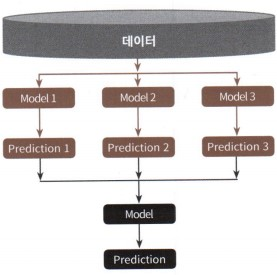

In [ ]:
from IPython.display import Image

Image('/content/분류_앙상블3_스테킹1.jpg')

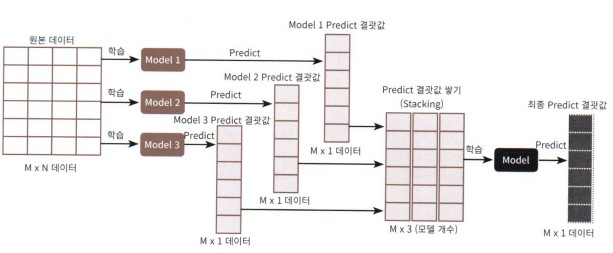

In [ ]:
Image('/content/분류_앙상블3_스테킹2.jpg')

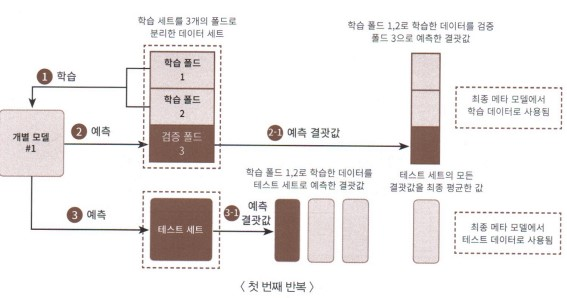

In [ ]:
Image('/content/분류_앙상블3_스테킹3.jpg')

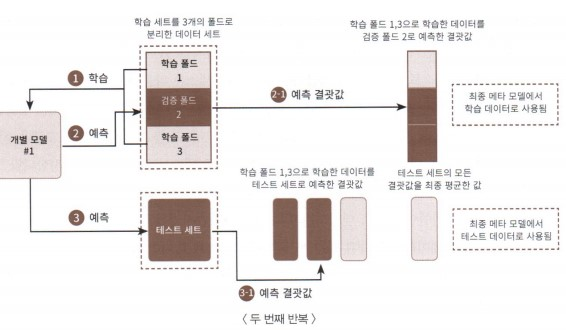

In [ ]:
Image('/content/분류_앙상블3_스테킹4.jpg')

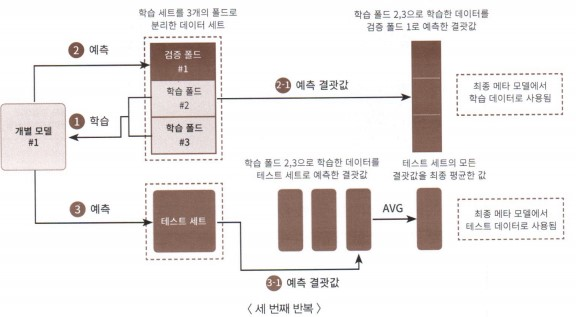

In [ ]:
Image('/content/분류_앙상블3_스테킹5.jpg')

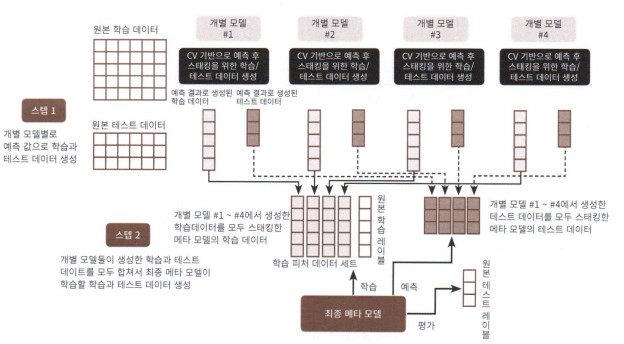

In [ ]:
Image('/content/분류_앙상블3_스테킹6.jpg')

## 학습

- [ ] 일반 학습
- 교차 검증 학습
  - [ ] 일반 K-Fold 교차 검증
  - [ ] 층화 K-Fold 교차 검증

# 시스템 구축

- 모델 덤프 -> 서빙(엔드포인트 구성(api 구성) -> 버전관리등등
  - `MLOps` 연관을 맺음
- 심화 과정에서는 생략
  - 단 시뮬레이션 통해 묘사(gradio 활용)